In [1]:
import os
import cv2
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import itertools
from sklearn.metrics import confusion_matrix


In [2]:
# Ignore the warning
warnings.filterwarnings("ignore")
# Auto-reload extensions
%reload_ext autoreload
%autoreload 2
# Display Matplotlib plots inline
%matplotlib inline

# Data Exploration
1. remove the Grayscale images
2. resize images
3. normalization
4. argumentation

In [ ]:
##### Load the data from zipfile locally#####

# import zipfile

# zip_file_path = os.path.join('..', 'raw_data', 'archive.zip')b
# extract_dir = os.path.join('..', 'raw_data', 'cnn_data')

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# extracted_files = os.listdir(extract_dir)
# print("Extracted files:", extracted_files)

## Display the dataset of each Class

In [ ]:
# Function to display a grid of images
def display_images(images, titles, rows=5, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(13, 10))
    axes = axes.flatten()
    for img, ax, title in zip(images, axes, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Load the dataset from the directory
base_folder_path = '../raw_data/cnn_data/architectural-styles-dataset'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    base_folder_path,
    image_size=(256, 256),  # Adjust the image size as needed
    shuffle=False,
)

# Extract class names
class_names = dataset.class_names

# Select one image from each folder
sample_images = []
sample_titles = []

for class_name in class_names:
    class_dir = os.path.join(base_folder_path, class_name)
    # Get the list of all images in the folder
    image_files = os.listdir(class_dir)
    # Randomly select one image from the folder
    selected_image = random.choice(image_files)
    # Load one image from the directory
    img_path = os.path.join(class_dir, selected_image)
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(256, 256))
    img = np.array(img)
    sample_images.append(img)
    sample_titles.append(class_name)

# Display the selected images
display_images(sample_images, sample_titles, rows=5, cols=5)

NotFoundError: Could not find directory /content/drive/MyDrive/architectural-styles-dataset/

## Remove Grayscale images

In [ ]:
styles = [
    'Achaemenid architecture',
    'American craftsman style',
    'American Foursquare architecture',
    'Ancient Egyptian architecture',
    'Art Deco architecture',
    'Art Nouveau architecture',
    'Baroque architecture',
    'Bauhaus architecture',
    'Beaux-Arts architecture',
    'Byzantine architecture',
    'Chicago school architecture',
    'Colonial architecture',
    'Deconstructivism',
    'Edwardian architecture',
    'Georgian architecture',
    'Gothic architecture',
    'Greek Revival architecture',
    'International style',
    'Novelty architecture',
    'Palladian architecture',
    'Postmodern architecture',
    'Queen Anne architecture',
    'Romanesque architecture',
    'Russian Revival architecture',
    'Tudor Revival architecture'
]

In [ ]:
from PIL import Image

base_folder_path = '../raw_data/cnn_data/architectural-styles-dataset'

def black_white(image_path):
    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image)

    if np.all(image_array[:, :, 0] == image_array[:, :, 1]) and  np.all(image_array[:, :, 1]== image_array[:, :, 2]):
        return True
    else:
        return False


def process_images_in_style(style_name):
    folder_path = os.path.join(base_folder_path, style_name)
    deleted_count = 0
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return

    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        if black_white(image_path):
            os.remove(image_path)
            deleted_count += 1
#             print(f"Grayscale image found: {file_name} in {style_name}")

    print(f"Deleted {deleted_count} files in the {style_name}")


In [ ]:
# Process images for each folder
for style in styles:
    print(f"Processing images for style: {style}")
    process_images_in_style(style)

Processing images for style: Achaemenid architecture
Deleted 0 files in the Achaemenid architecture
Processing images for style: American craftsman style
Deleted 0 files in the American craftsman style
Processing images for style: American Foursquare architecture
Deleted 0 files in the American Foursquare architecture
Processing images for style: Ancient Egyptian architecture
Deleted 0 files in the Ancient Egyptian architecture
Processing images for style: Art Deco architecture
Deleted 0 files in the Art Deco architecture
Processing images for style: Art Nouveau architecture
Deleted 0 files in the Art Nouveau architecture
Processing images for style: Baroque architecture
Deleted 0 files in the Baroque architecture
Processing images for style: Bauhaus architecture
Deleted 0 files in the Bauhaus architecture
Processing images for style: Beaux-Arts architecture
Deleted 0 files in the Beaux-Arts architecture
Processing images for style: Byzantine architecture
Deleted 0 files in the Byzanti

## Split the dataset into Train/Val/Test

In [ ]:
import shutil
import random

# Define the base directory where the data is currently located
base_dir = '../raw_data/cnn_data/architectural-styles-dataset'
# Define the new base directory where the train/val/test folders will be created
new_base_dir = '../raw_data/cnn_data'

# Create directories for train, val, and test sets
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
test_dir = os.path.join(new_base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


# Function to split and copy files
def split_and_copy_files(style_name):
    source_folder = os.path.join(base_dir, style_name)
    if not os.path.exists(source_folder):
        print(f"Folder not found: {source_folder}")
        return

    files = os.listdir(source_folder)
    random.shuffle(files)

    # Calculate split indices
    total_files = len(files)
    train_count = int(0.7 * total_files)
    val_count = int(0.15 * total_files)

    train_files = files[:train_count]
    val_files = files[train_count:train_count + val_count]
    test_files = files[train_count + val_count:]

    # Create style-specific directories in train, val, and test folders
    train_style_dir = os.path.join(train_dir, style_name)
    val_style_dir = os.path.join(val_dir, style_name)
    test_style_dir = os.path.join(test_dir, style_name)

    os.makedirs(train_style_dir, exist_ok=True)
    os.makedirs(val_style_dir, exist_ok=True)
    os.makedirs(test_style_dir, exist_ok=True)

    # Copy files to respective directories
    for file_name in train_files:
        shutil.copy(os.path.join(source_folder, file_name), os.path.join(train_style_dir, file_name))

    for file_name in val_files:
        shutil.copy(os.path.join(source_folder, file_name), os.path.join(val_style_dir, file_name))

    for file_name in test_files:
        shutil.copy(os.path.join(source_folder, file_name), os.path.join(test_style_dir, file_name))

    print(f"Processed {style_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")


# Split and copy files for each style
for style in styles:
    split_and_copy_files(style)

## Resize the Images

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

# Define the batch size
batch_size = 32

train_ds = image_dataset_from_directory(
  train_dir,
  labels = "inferred",
  label_mode = "int",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

# We define a second one for the test data
val_ds = image_dataset_from_directory(
  val_dir,
  labels = "inferred",
  label_mode = "int",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

test_ds = image_dataset_from_directory(
  test_dir,
  labels = "inferred",
  label_mode = "int",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

Found 6918 files belonging to 25 classes.
Found 1472 files belonging to 25 classes.
Found 1511 files belonging to 25 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


In [ ]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Data Normalize and Augmentation

In [3]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.data import AUTOTUNE

# Define data augmentation layers
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomTranslation(0.2, 0.2)
])

In [ ]:
# Normalize the data
normalization_layer = Rescaling(1./255)

# Apply the normalization layer to the datasets
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y), num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# Prefetch the datasets for better performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

NameError: name 'train_ds' is not defined

In [ ]:
train_ds

# Loading Dataset from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [5]:
train_drive_dir = '/content/drive/MyDrive/architectural-styles-dataset/train'
val_drive_dir = '/content/drive/MyDrive/architectural-styles-dataset/val'
test_drive_dir = '/content/drive/MyDrive/architectural-styles-dataset/test'

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory

# Define the batch size
batch_size = 32

train_data = image_dataset_from_directory(
  train_drive_dir,
  labels = "inferred",
  label_mode = "int",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

# We define a second one for the test data
val_data = image_dataset_from_directory(
  val_drive_dir,
  labels = "inferred",
  label_mode = "int",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

test_data = image_dataset_from_directory(
  test_drive_dir,
  labels = "inferred",
  label_mode = "int",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

Found 6446 files belonging to 24 classes.
Found 1371 files belonging to 24 classes.
Found 1412 files belonging to 24 classes.


In [7]:
class_names = train_data.class_names
print(class_names)

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


In [8]:
# Normalize the data
normalization_layer = Rescaling(1./255)

# Apply the normalization layer to the datasets
train_data = train_data.map(lambda x, y: (data_augmentation(normalization_layer(x)), y), num_parallel_calls=tf.data.AUTOTUNE)

val_data = val_data.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_data = test_data.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# Prefetch the datasets for better performance
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

### Check if the image preprocess successfully

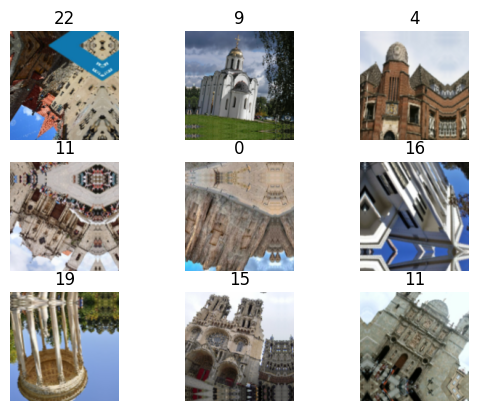

In [ ]:
# Check if the images has been augmentated sucessfully
import matplotlib.pyplot as plt

for images, labels in train_data.take(1):  # Take a batch from the train_data
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())  # No conversion
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

In [ ]:
# Check if the images has been normalized sucessfully

for images, _ in train_data.take(1):  # Take a batch from the train_data
    print("Min pixel value:", tf.reduce_min(images).numpy())
    print("Max pixel value:", tf.reduce_max(images).numpy())


Min pixel value: 0.0
Max pixel value: 1.0


In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### Check the number of each classes

In [ ]:
import os

# Define paths to the 'train', 'test', and 'validation' folders
folders = {
    'train': '/content/drive/MyDrive/architectural-styles-dataset/train',
    'test': '/content/drive/MyDrive/architectural-styles-dataset/test',
    'validation': '/content/drive/MyDrive/architectural-styles-dataset/val'
}

# Dictionary to store the image count and percentage
image_count = {}

# Loop through each main folder
for folder_name, folder_path in folders.items():
    image_count[folder_name] = {}
    total_images = 0

    # First, count the total number of images in the main folder
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            total_images += num_images

    # Now, calculate the number of images and percentage for each class
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            percentage = (num_images / total_images) * 100
            image_count[folder_name][class_name] = (num_images, percentage)

# Display the image count and percentage
for folder_name, classes in image_count.items():
    print(f"\n{folder_name.capitalize()} folder:")
    for class_name, (num_images, percentage) in classes.items():
        print(f"  {class_name}: {num_images} images ({percentage:.2f}%)")



Train folder:
  Chicago school architecture: 185 images (2.83%)
  Baroque architecture: 317 images (4.85%)
  American craftsman style: 253 images (3.87%)
  Greek Revival architecture: 343 images (5.24%)
  American Foursquare architecture: 249 images (3.81%)
  Queen Anne architecture: 497 images (7.60%)
  Ancient Egyptian architecture: 283 images (4.33%)
  Edwardian architecture: 218 images (3.33%)
  Achaemenid architecture: 273 images (4.17%)
  International style: 277 images (4.24%)
  Romanesque architecture: 233 images (3.56%)
  Georgian architecture: 264 images (4.04%)
  Tudor Revival architecture: 315 images (4.82%)
  Beaux-Arts architecture: 291 images (4.45%)
  Gothic architecture: 227 images (3.47%)
  Palladian architecture: 235 images (3.59%)
  Deconstructivism: 233 images (3.56%)
  Art Nouveau architecture: 393 images (6.01%)
  Postmodern architecture: 224 images (3.43%)
  Colonial architecture: 326 images (4.98%)
  Russian Revival architecture: 229 images (3.50%)
  Novelty a

# Build and Train Model

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img



def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [10]:
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

## 1. VGG16 Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))

In [ ]:
inputs = layers.Input(shape = (150, 150, 3))

# x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(x)
x = preprocess_input(inputs) # Then a preprocessing layer specifically designed for the VGG16
x = base_model(x) # Then our transfer learning model

x = layers.Flatten()(x) # Followed by our custom dense layers, tailored to our binary task

x = layers.Dense(64, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
pred = layers.Dense(25, activation = "softmax")(x)

# We use the keras Functional API to create our keras model

model_vgg = Model(inputs = inputs , outputs = pred)

# And we freeze the VGG16 model
base_model.trainable = False

In [ ]:
model_vgg.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 150, 150, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 64)                5243

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model_vgg.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
MODEL = "model_vgg"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [ ]:
%%time
history_vgg = model_vgg.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper])

Epoch 1/10
217/217 [==============================] - 751s 3s/step - loss: 3.2389 - accuracy: 0.0635 - val_loss: 3.2071 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 2/10
217/217 [==============================] - 670s 3s/step - loss: 3.2034 - accuracy: 0.0718 - val_loss: 3.1990 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 3/10
217/217 [==============================] - 1322s 6s/step - loss: 3.1969 - accuracy: 0.0718 - val_loss: 3.1937 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 4/10
217/217 [==============================] - 10963s 51s/step - loss: 3.1927 - accuracy: 0.0718 - val_loss: 3.1904 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 5/10
217/217 [==============================] - 513s 2s/step - loss: 3.1901 - accuracy: 0.0718 - val_loss: 3.1883 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 6/10
217/217 [==============================] - 517s 2s/step - loss: 3.1885 - accuracy: 0.0718 - val_loss: 3.1870 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 7/10
217/217 [==============================] - 524s 2

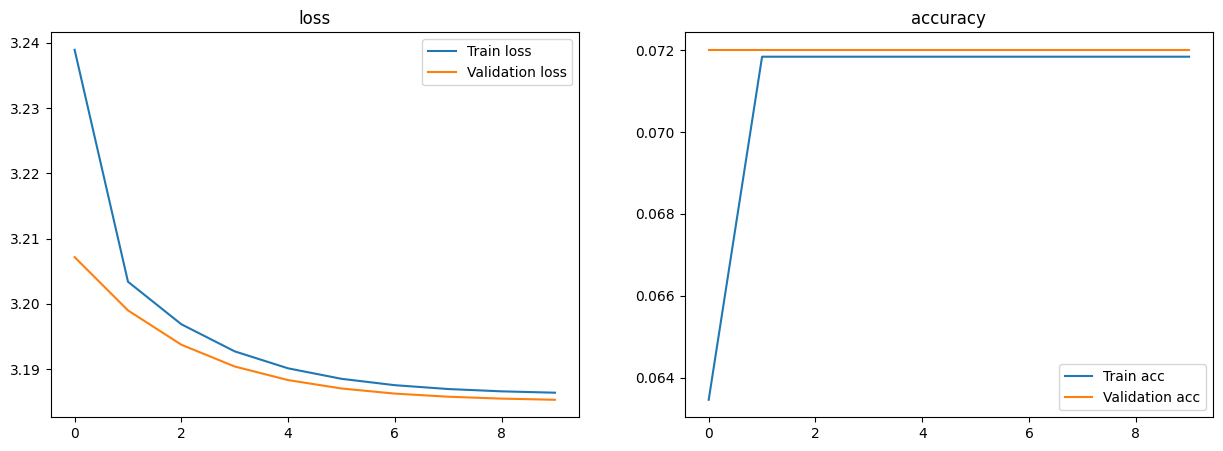

In [ ]:
plot_history(history_vgg)

## 2. CS231N Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

def create_cs231n_model(input_shape=(150, 150, 3), num_classes=25):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [ ]:
# Define input shape and number of classes
input_shape = (150, 150, 3)
num_classes = 25

model_cs231n  = create_cs231n_model(input_shape , num_classes)

In [ ]:
model_cs231n.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [ ]:
adam = optimizers.Adam(learning_rate = 0.001)
model_cs231n.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
modelCheckpoint = callbacks.ModelCheckpoint("model_cs231n.h5", monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [ ]:
history_cs231n = model_cs231n.fit(
        train_ds,
        epochs=20,
        validation_data=val_ds,
        callbacks=[modelCheckpoint, LRreducer, EarlyStopper]
)

Epoch 1/20
217/217 [==============================] - 97s 429ms/step - loss: 3.1946 - accuracy: 0.0588 - val_loss: 3.1084 - val_accuracy: 0.0910 - lr: 0.0010
Epoch 2/20
217/217 [==============================] - 71s 325ms/step - loss: 3.0142 - accuracy: 0.1182 - val_loss: 2.7922 - val_accuracy: 0.1522 - lr: 0.0010
Epoch 3/20
217/217 [==============================] - 67s 308ms/step - loss: 2.7995 - accuracy: 0.1619 - val_loss: 2.6099 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 4/20
217/217 [==============================] - 65s 299ms/step - loss: 2.6234 - accuracy: 0.2069 - val_loss: 2.4908 - val_accuracy: 0.2317 - lr: 0.0010
Epoch 5/20
217/217 [==============================] - 64s 294ms/step - loss: 2.4354 - accuracy: 0.2512 - val_loss: 2.3682 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 6/20
217/217 [==============================] - 64s 296ms/step - loss: 2.2583 - accuracy: 0.2981 - val_loss: 2.3606 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 7/20
217/217 [==============================] 

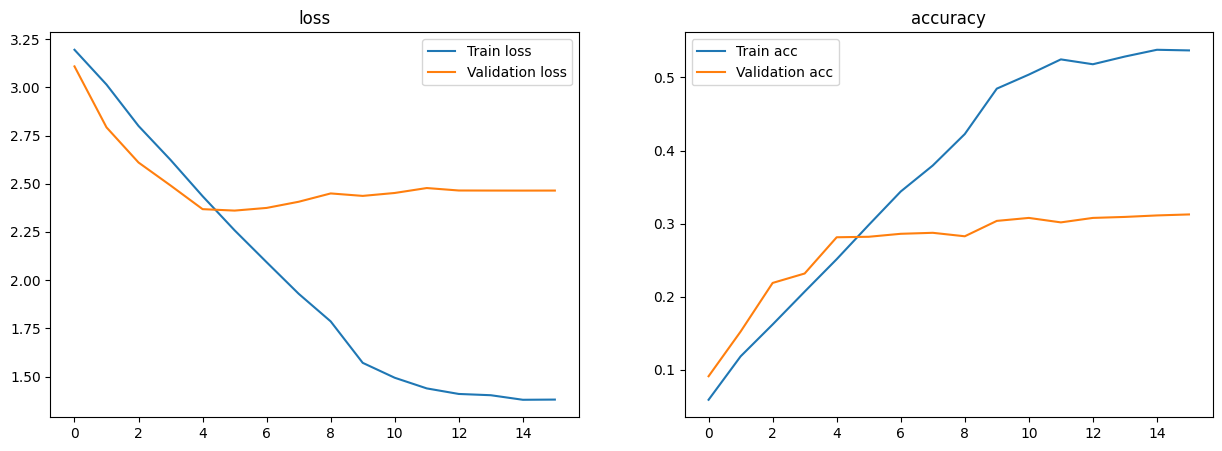

In [ ]:
plot_history(history_cs231n)

## 3. ResNet50 (Tensorflow) Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import layers, Model, optimizers, callbacks

base_model_2 = ResNet50(weights='imagenet',include_top=False, input_shape=(150, 150, 3))

inputs = layers.Input(shape=(150,150,3))
x = preprocess_input(inputs)
x = base_model_2(x)
x = layers.Flatten()(x)
pred = layers.Dense(25, activation='softmax')(x)

model_resnet = Model(inputs=inputs, outputs=pred)

# Freeze the ResNet50 base model
base_model_2.trainable = False

# Compile the model
adam = optimizers.Adam(learning_rate=0.001)
model_resnet.compile(loss='sparse_categorical_crossentropy',
                     optimizer=adam,
                     metrics=['accuracy'])

# Define callbacks
modelCheckpoint = callbacks.ModelCheckpoint("model_resnet.keras", monitor="val_loss", verbose=0, save_best_only=True)
LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1, min_lr=0)
EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
%%time
history_resnet = model_resnet.fit(
        train_data,
        epochs=30,
        validation_data=val_data,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper])

Epoch 1/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 3270s 15s/step - accuracy: 0.0719 - loss: 4.0738 - val_accuracy: 0.0837 - val_loss: 3.4650 - learning_rate: 0.0010
Epoch 2/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.1102 - loss: 3.4080 - val_accuracy: 0.0960 - val_loss: 3.4338 - learning_rate: 0.0010
Epoch 3/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.1309 - loss: 3.2764 - val_accuracy: 0.0994 - val_loss: 3.4267 - learning_rate: 0.0010
Epoch 4/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.1548 - loss: 3.1714 - val_accuracy: 0.1055 - val_loss: 3.4394 - learning_rate: 0.0010
Epoch 5/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.1720 - loss: 3.0848 - val_accuracy: 0.1137 - val_loss: 3.4556 - learning_rate: 0.0010
Epoch 6/30
216/216 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1859 - loss: 3.0109
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
216/216 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - accuracy: 0.1859 - l

## 4. Fastai Model

In [ ]:
from fastai.vision.all import *
from fastai.vision.augment import aug_transforms

In [ ]:
path_data = '/content/drive/MyDrive/architectural-styles-dataset'

preprocessing = ImageDataLoaders.from_folder(path_data,train='train',valid='val',
                                             item_tfms=Resize(150),
                                             batch_tfms=aug_transforms(do_flip=True,max_rotate=30,max_zoom=1.5,max_lighting=0.2,p_affine=0.75) )


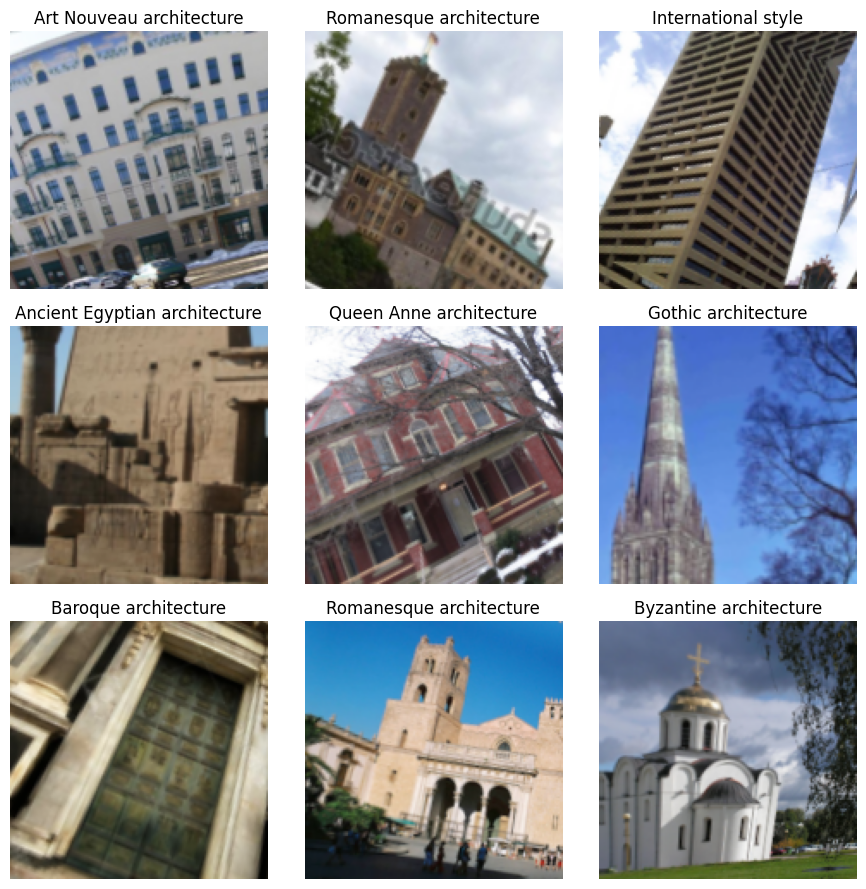

In [ ]:
preprocessing.show_batch(max_n=9)
plt.tight_layout()
plt.show()

In [ ]:
learn = vision_learner(preprocessing, resnet50, metrics=accuracy)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,2.879712,1.720410,0.493533,01:55


epoch,train_loss,valid_loss,accuracy,time
0,2.010333,1.432643,0.571818,01:48
1,1.708769,1.335472,0.616746,01:49
2,1.425372,1.242021,0.635807,01:49
3,1.218297,1.174437,0.658271,01:49
4,1.024733,1.111499,0.672566,01:50
5,0.881052,1.144154,0.679374,01:48
6,0.761986,1.083642,0.685500,01:52
7,0.640858,1.108506,0.699796,01:48
8,0.595421,1.057786,0.695031,01:50
9,0.572417,1.098830,0.703199,01:49


In [ ]:
learn.save('resnet50-architecture-classifier')

Path('/content/drive/MyDrive/architectural-styles-dataset/models/resnet50-architecture-classifier.pth')

## Fine Tune Fastai Model

In [11]:
from fastai.vision.all import *
from fastai.vision.augment import aug_transforms

path_data = '/content/drive/MyDrive/architectural-styles-dataset'

preprocessing_fine = ImageDataLoaders.from_folder(path_data,train='train',valid='val',
                                             item_tfms=Resize(224),
                                             batch_tfms=[*aug_transforms(do_flip=True,max_rotate=20,max_zoom=1.5,max_lighting=0.2,p_affine=0.5),
                                                  Normalize.from_stats(*imagenet_stats)])

In [12]:
learn = vision_learner(preprocessing_fine, resnet50, metrics=accuracy)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s]


SuggestedLRs(valley=0.0006918309954926372)

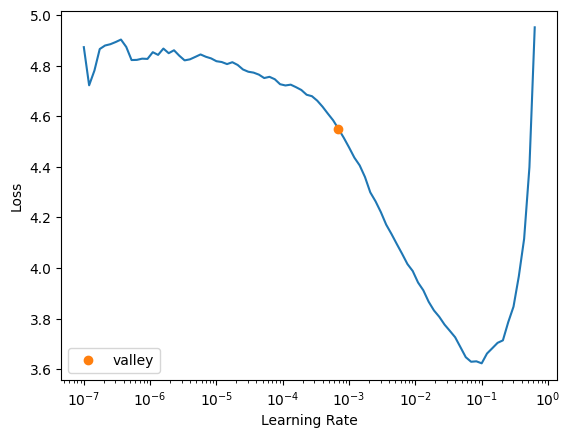

In [ ]:
learn.lr_find()

In [15]:
learn.fine_tune(100,base_lr=0.0006)

epoch,train_loss,valid_loss,accuracy,time
0,2.533244,1.567082,0.541278,16:50


epoch,train_loss,valid_loss,accuracy,time
0,1.921963,1.451015,0.577889,02:03
1,1.776427,1.365934,0.602297,02:03
2,1.697191,1.292896,0.606604,02:02
3,1.580178,1.267140,0.625987,02:01
4,1.485842,1.213198,0.637473,02:03
5,1.425711,1.197452,0.645370,02:02
6,1.351755,1.138381,0.662599,02:01
7,1.269059,1.096204,0.673367,02:01
8,1.205568,1.097151,0.675520,02:02
9,1.125633,1.068576,0.687006,02:00


<Figure size 1200x800 with 0 Axes>

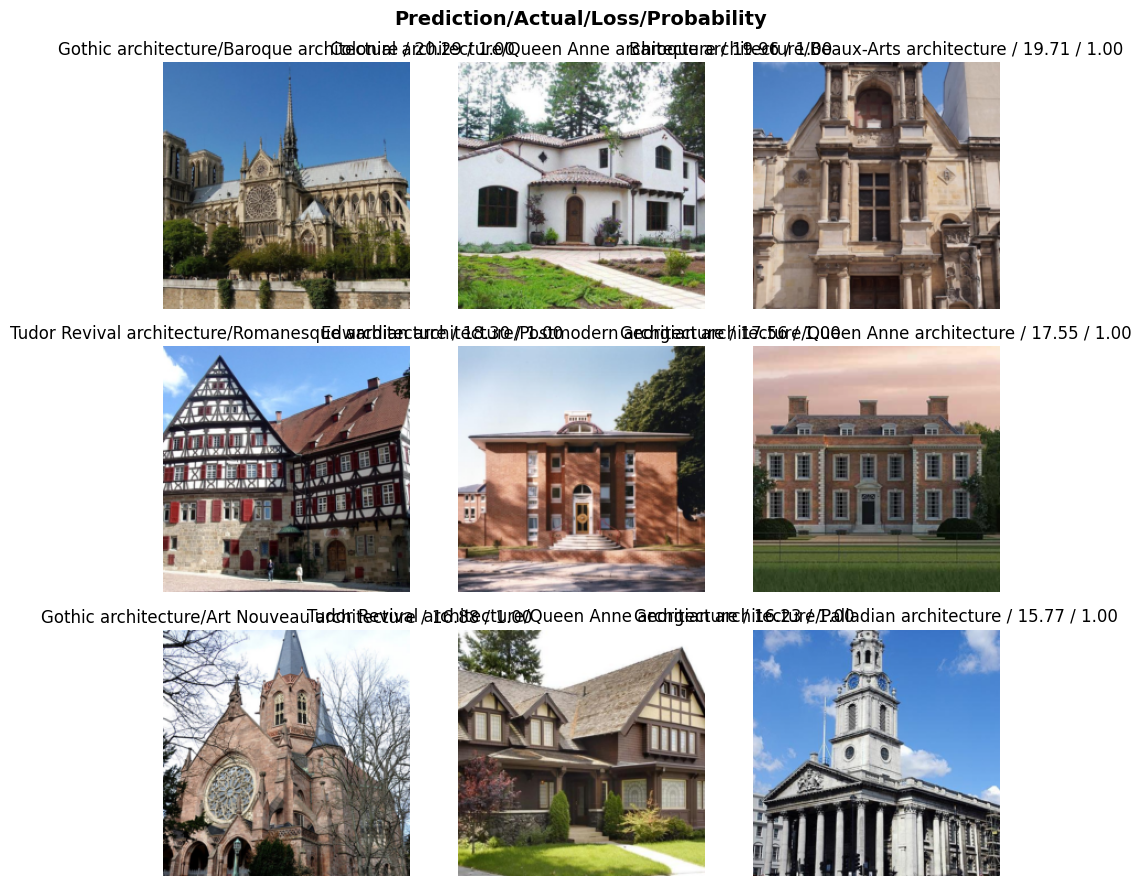

In [16]:
# Top Losses
plt.figure(figsize=(12, 8))

interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)
plt.tight_layout()
plt.show()

In [23]:
val_loss, val_metrics = learn.validate()
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_metrics}")

Validation Loss: 1.2131662368774414
Validation Accuracy: 0.7832016944885254


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

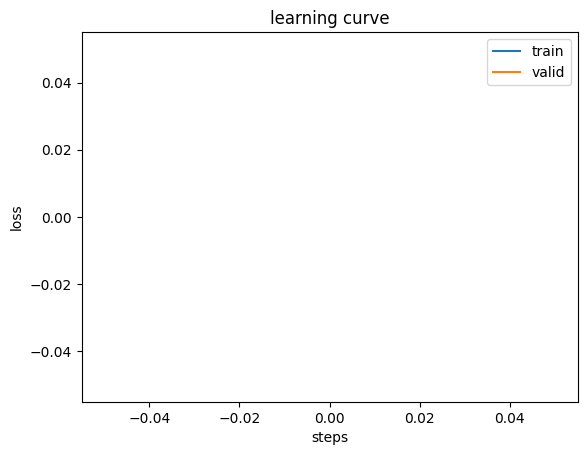

In [20]:
# Plot the learning curves to see if the model is underfitting or overfitting.
val_loss, val_metrics = learn.validate()

learn.recorder.plot_loss()

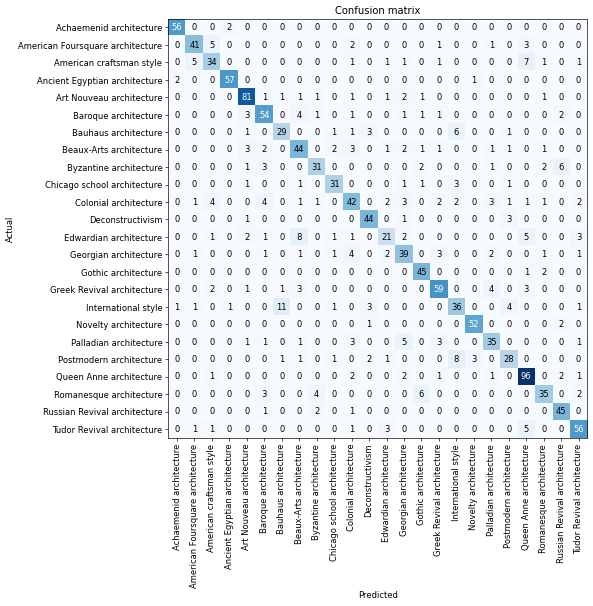

In [18]:
# Confusion Matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [19]:
# Classification Report
from sklearn.metrics import classification_report

preds, y_true = learn.get_preds()
y_pred = preds.argmax(dim=1)
print(classification_report(y_true, y_pred, target_names=learn.dls.vocab))


                                  precision    recall  f1-score   support

         Achaemenid architecture       0.95      0.97      0.96        58
American Foursquare architecture       0.82      0.77      0.80        53
        American craftsman style       0.71      0.65      0.68        52
   Ancient Egyptian architecture       0.95      0.95      0.95        60
        Art Nouveau architecture       0.85      0.89      0.87        91
            Baroque architecture       0.76      0.79      0.78        68
            Bauhaus architecture       0.67      0.69      0.68        42
         Beaux-Arts architecture       0.68      0.71      0.69        62
          Byzantine architecture       0.78      0.67      0.72        46
     Chicago school architecture       0.82      0.79      0.81        39
           Colonial architecture       0.67      0.60      0.63        70
                Deconstructivism       0.83      0.90      0.86        49
          Edwardian architecture     

In [24]:
learn.save('resnet50_finetune_architecture')

Path('/content/drive/MyDrive/architectural-styles-dataset/models/resnet50_finetune_architecture.pth')